# 🌿 Seasonal Allergy & Pollen Analysis — Berlin, Germany (2021–2025)

This notebook analyzes **5 years of hourly pollen and weather data** for Berlin using the [Open-Meteo Air Quality API](https://open-meteo.com/en/docs/air-quality-api) — one of the few free sources of historical pollen data with actual grain counts (grains/m³). See the project [README](../README.md) for details on data source selection.

**5 pollen types analyzed**: Birch, Grass, Ragweed, Alder, Mugwort
**Weather factors**: Temperature, humidity, wind speed, precipitation

### Questions
1. Which pollen types dominate each season?
2. Are allergy seasons getting worse over time?
3. Does weather correlate with higher pollen counts?
4. What does a typical "allergy calendar" look like?

### Severity Scale (AAAAI)
Pollen levels are classified using thresholds from the **American Academy of Allergy, Asthma & Immunology**:

| Level | Tree Pollen | Grass Pollen | Weed Pollen |
|-------|------------|-------------|-------------|
| Low | 1–14 | 1–4 | 1–9 |
| Moderate | 15–89 | 5–19 | 10–49 |
| High | 90–1,499 | 20–199 | 50–499 |
| Very High | ≥1,500 | ≥200 | ≥500 |

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from datetime import datetime
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 1. Data Collection

Fetching **5 years** of hourly pollen + weather data from Open-Meteo for Berlin (52.52°N, 13.41°E).

In [2]:
# ── Configuration ──
LATITUDE = 52.52
LONGITUDE = 13.41
CITY = "Berlin"
START_YEAR = 2021
END_YEAR = 2025

POLLEN_VARS = "alder_pollen,birch_pollen,grass_pollen,mugwort_pollen,ragweed_pollen"
WEATHER_VARS = "temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation"

AIR_QUALITY_URL = "https://air-quality-api.open-meteo.com/v1/air-quality"
WEATHER_URL = "https://archive-api.open-meteo.com/v1/archive"

# ── Fetch pollen data year by year ──
pollen_frames = []
weather_frames = []

for year in range(START_YEAR, END_YEAR + 1):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Pollen data
    pollen_params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": POLLEN_VARS,
        "timezone": "auto"
    }
    r = requests.get(AIR_QUALITY_URL, params=pollen_params)
    r.raise_for_status()
    data = r.json()
    df = pd.DataFrame(data["hourly"])
    pollen_frames.append(df)

    # Weather data
    weather_params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": WEATHER_VARS,
        "timezone": "auto"
    }
    r = requests.get(WEATHER_URL, params=weather_params)
    r.raise_for_status()
    data = r.json()
    wdf = pd.DataFrame(data["hourly"])
    weather_frames.append(wdf)

    print(f"  ✅ {year} fetched")

# Combine all years
pollen_df = pd.concat(pollen_frames, ignore_index=True)
weather_df = pd.concat(weather_frames, ignore_index=True)

print(f"\n📊 Pollen data: {len(pollen_df):,} hourly records ({START_YEAR}–{END_YEAR})")
print(f"🌤️  Weather data: {len(weather_df):,} hourly records ({START_YEAR}–{END_YEAR})")

  ✅ 2021 fetched
  ✅ 2022 fetched
  ✅ 2023 fetched
  ✅ 2024 fetched
  ✅ 2025 fetched

📊 Pollen data: 43,824 hourly records (2021–2025)
🌤️  Weather data: 43,824 hourly records (2021–2025)


In [3]:
# ── Merge pollen + weather on timestamp ──
pollen_df["time"] = pd.to_datetime(pollen_df["time"])
weather_df["time"] = pd.to_datetime(weather_df["time"])

df = pd.merge(pollen_df, weather_df, on="time", how="inner")

# Ensure pollen columns are numeric
pollen_cols = ["alder_pollen", "birch_pollen", "grass_pollen", "mugwort_pollen", "ragweed_pollen"]
for col in pollen_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Add time-based columns for analysis
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["month_name"] = df["time"].dt.strftime("%b")
df["day_of_year"] = df["time"].dt.dayofyear
df["hour"] = df["time"].dt.hour
df["date"] = df["time"].dt.date
df["season"] = df["month"].map({
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
})

# Rename columns for readability
df = df.rename(columns={
    "alder_pollen": "Alder",
    "birch_pollen": "Birch",
    "grass_pollen": "Grass",
    "mugwort_pollen": "Mugwort",
    "ragweed_pollen": "Ragweed",
    "temperature_2m": "Temperature (°C)",
    "relative_humidity_2m": "Humidity (%)",
    "wind_speed_10m": "Wind Speed (km/h)",
    "precipitation": "Precipitation (mm)"
})

POLLEN_TYPES = ["Alder", "Birch", "Grass", "Mugwort", "Ragweed"]

# Fill NaN pollen values with 0 (NaN means no pollen detected / out of season)
df[POLLEN_TYPES] = df[POLLEN_TYPES].fillna(0)

# Quick overview
print(f"📋 Combined dataset: {len(df):,} rows × {len(df.columns)} columns")
print(f"📅 Date range: {df['time'].min().date()} → {df['time'].max().date()}")
print(f"\n── Pollen summary (grains/m³) ──")
df[POLLEN_TYPES].describe().round(1)

📋 Combined dataset: 43,824 rows × 17 columns
📅 Date range: 2021-01-01 → 2025-12-31

── Pollen summary (grains/m³) ──


,Alder,Birch,Grass,Mugwort,Ragweed
count,43824.0,43824.0,43824.0,43824.0,43824.0
mean,0.4,12.8,3.1,1.9,0.6
std,6.2,78.7,7.7,7.5,4.1
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,1.5,0.0,0.0
max,361.5,2552.7,70.4,121.3,101.7


In [4]:
# ── Save to CSV for future use (avoids re-fetching) ──
csv_path = os.path.join("data", f"{CITY.lower()}_pollen_weather_{START_YEAR}_{END_YEAR}.csv")
df.to_csv(csv_path, index=False)
print(f"💾 Saved to {csv_path} ({os.path.getsize(csv_path) / 1e6:.1f} MB)")

💾 Saved to data/berlin_pollen_weather_2021_2025.csv (4.0 MB)


## 2. Severity Classification (AAAAI Scale)

Applying the official thresholds from the American Academy of Allergy, Asthma & Immunology. Note that the scale differs by pollen category — tree pollen is far more prolific than grass or weed pollen, so "High" for trees starts at 90 gr/m³ while "High" for grass starts at just 20 gr/m³.

We map each of the 5 species to its category:
- **Tree pollen**: Alder, Birch
- **Grass pollen**: Grass
- **Weed pollen**: Mugwort, Ragweed

In [5]:
# ── AAAAI severity thresholds (grains/m³) ──
# Source: American Academy of Allergy, Asthma & Immunology (AAAAI)
SEVERITY_THRESHOLDS = {
    "tree":  {"Low": (1, 14), "Moderate": (15, 89), "High": (90, 1499), "Very High": (1500, float("inf"))},
    "grass": {"Low": (1, 4),  "Moderate": (5, 19),  "High": (20, 199),  "Very High": (200, float("inf"))},
    "weed":  {"Low": (1, 9),  "Moderate": (10, 49), "High": (50, 499),  "Very High": (500, float("inf"))},
}

# Map each pollen species to its AAAAI category
SPECIES_CATEGORY = {
    "Alder": "tree",
    "Birch": "tree",
    "Grass": "grass",
    "Mugwort": "weed",
    "Ragweed": "weed",
}

def classify_severity(value: float, category: str) -> str:
    """Classify a pollen grain count into AAAAI severity level."""
    if pd.isna(value) or value < 1:
        return "Absent"
    thresholds = SEVERITY_THRESHOLDS[category]
    for level, (low, high) in thresholds.items():
        if low <= value <= high:
            return level
    return "Absent"

# Apply severity classification to each pollen type
for species in POLLEN_TYPES:
    category = SPECIES_CATEGORY[species]
    df[f"{species}_severity"] = df[species].apply(lambda v: classify_severity(v, category))

# Show distribution of severity levels
severity_cols = [f"{s}_severity" for s in POLLEN_TYPES]
print("── Severity Distribution ──\n")
for species in POLLEN_TYPES:
    col = f"{species}_severity"
    counts = df[col].value_counts()
    total = len(df)
    non_absent = total - counts.get("Absent", 0)
    pct_active = non_absent / total * 100
    print(f"  {species:10s} — Active {pct_active:.1f}% of hours | "
          f"High+Very High: {(counts.get('High', 0) + counts.get('Very High', 0)) / total * 100:.1f}%")
    

── Severity Distribution ──

  Alder      — Active 3.0% of hours | High+Very High: 0.1%
  Birch      — Active 12.3% of hours | High+Very High: 3.3%
  Grass      — Active 26.5% of hours | High+Very High: 5.3%
  Mugwort    — Active 13.9% of hours | High+Very High: 0.5%
  Ragweed    — Active 5.3% of hours | High+Very High: 0.2%


In [6]:
# For each day, check if ANY species hit High or Very High at any hour
severity_cols = [f'{species}_severity' for species in POLLEN_TYPES]

df['is_high_day'] = df[severity_cols].isin(['High', 'Very High']).any(axis=1)

# Collapse to one row per date — a day counts as "high" if any hour qualifies
daily_flags = df.groupby(['date', 'month']).agg(high_day=('is_high_day', 'max')).reset_index()

# Per month: % of days that were high/very-high allergy days
monthly_pct = (
    daily_flags.groupby('month')['high_day']
    .agg(total_days='count', high_days='sum')
)
monthly_pct['pct_high'] = (monthly_pct['high_days'] / monthly_pct['total_days'] * 100).round(1)

month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
monthly_pct.index = monthly_pct.index.map(month_names)

print("% of days with High or Very High pollen (any species)\n")
print(monthly_pct.to_string())

% of days with High or Very High pollen (any species)

       total_days  high_days  pct_high
month                                 
Jan           155          0       0.0
Feb           141          2       1.4
Mar           155         14       9.0
Apr           150         82      54.7
May           155         33      21.3
Jun           150        142      94.7
Jul           155         52      33.5
Aug           155         23      14.8
Sep           150         37      24.7
Oct           155          0       0.0
Nov           150          0       0.0
Dec           155          0       0.0


In [ ]:
# Calculate total days per month across all years
days_per_month = df.groupby('month')['date'].nunique()

# Month names for cleaner output
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

for species in POLLEN_TYPES:
    print(f"\n{'='*60}")
    print(f"{species} - High/Very High Days per Month")
    print(f"{'='*60}")
    
    # Filter to High / Very High severity
    df_high = df[(df[species + '_severity'] == 'High') | (df[species + '_severity'] == 'Very High')]
    
    # Count unique high days per month
    high_counts = df_high.groupby('month')['date'].nunique()
    
    # Create a complete series for all 12 months (fill missing with 0)
    high_counts_full = high_counts.reindex(range(1, 13), fill_value=0)
    
    # Calculate percentages
    pct_high = (high_counts_full / days_per_month * 100).round(1)
    
    # Display results in a nice format
    print(f"\n{'Month':<10} {'High Days':<12} {'Total Days':<12} {'Percentage'}")
    print(f"{'-'*50}")
    
    for month in range(1, 13):
        high = int(high_counts_full[month])
        total = int(days_per_month[month])
        pct = pct_high[month]
        
        # Only show non-zero rows 
        if high > 0:
            print(f"{month_names[month]:<10} {high:<12} {total:<12} {pct:.1f}%")
    
    # Show total stats
    total_high_days = int(high_counts_full.sum())
    total_days = int(days_per_month.sum())
    overall_pct = round(total_high_days / total_days * 100, 1)
    print(f"{'-'*50}")
    print(f"{'TOTAL':<10} {total_high_days:<12} {total_days:<12} {overall_pct:.1f}%")


Alder - High/Very High Days per Month

Month      High Days    Total Days   Percentage
--------------------------------------------------
Feb        2            141          1.4%
Mar        6            155          3.9%
--------------------------------------------------
TOTAL      8            1826         0.4%

Birch - High/Very High Days per Month

Month      High Days    Total Days   Percentage
--------------------------------------------------
Mar        8            155          5.2%
Apr        82           150          54.7%
May        24           155          15.5%
--------------------------------------------------
TOTAL      114          1826         6.2%

Grass - High/Very High Days per Month

Month      High Days    Total Days   Percentage
--------------------------------------------------
May        9            155          5.8%
Jun        142          150          94.7%
Jul        29           155          18.7%
--------------------------------------------------
TOTAL 

## 3. Monthly Pollen Trends — Which Months Are Worst?

Aggregating average pollen counts by month across all 5 years to see the seasonal pattern for each allergen.

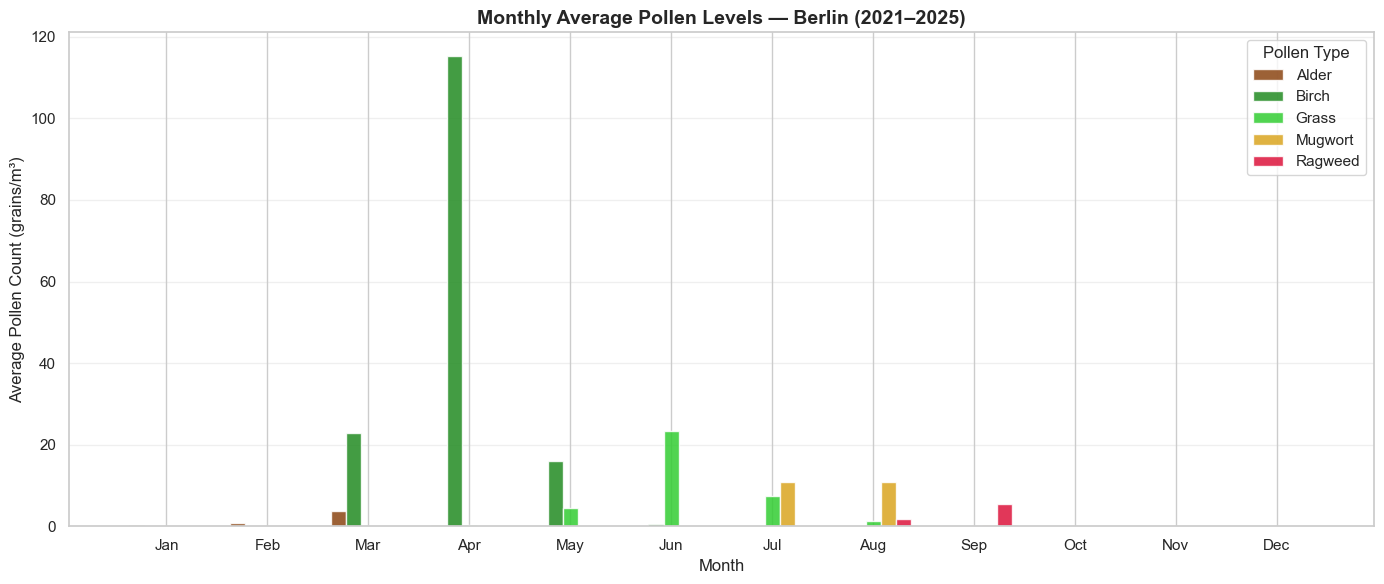


📌 Key takeaway: Each allergen has a distinct peak season —
   tree pollens (Alder, Birch) peak in spring, Grass in summer, weeds in late summer/fall.


In [8]:
# ── Monthly average pollen counts ──
monthly = df.groupby("month")[POLLEN_TYPES].mean()
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Color palette for each pollen type
pollen_colors = {
    "Alder": "#8B4513",
    "Birch": "#228B22",
    "Grass": "#32CD32",
    "Mugwort": "#DAA520",
    "Ragweed": "#DC143C"
}

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(12)
width = 0.15

for i, species in enumerate(POLLEN_TYPES):
    bars = ax.bar(x + i * width, monthly[species], width,
                  label=species, color=pollen_colors[species], alpha=0.85)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Average Pollen Count (grains/m³)", fontsize=12)
ax.set_title(f"Monthly Average Pollen Levels — {CITY} ({START_YEAR}–{END_YEAR})",
             fontsize=14, fontweight="bold")
ax.set_xticks(x + width * 2)
ax.set_xticklabels(month_labels)
ax.legend(title="Pollen Type", frameon=True)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("data/monthly_pollen_trends.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n📌 Key takeaway: Each allergen has a distinct peak season —")
print("   tree pollens (Alder, Birch) peak in spring, Grass in summer, weeds in late summer/fall.")

## 4. Year-Over-Year Trends — Are Allergies Getting Worse?

Climate change is hypothesized to lengthen pollen seasons and increase pollen production. Let's see if the data supports that over 5 years.

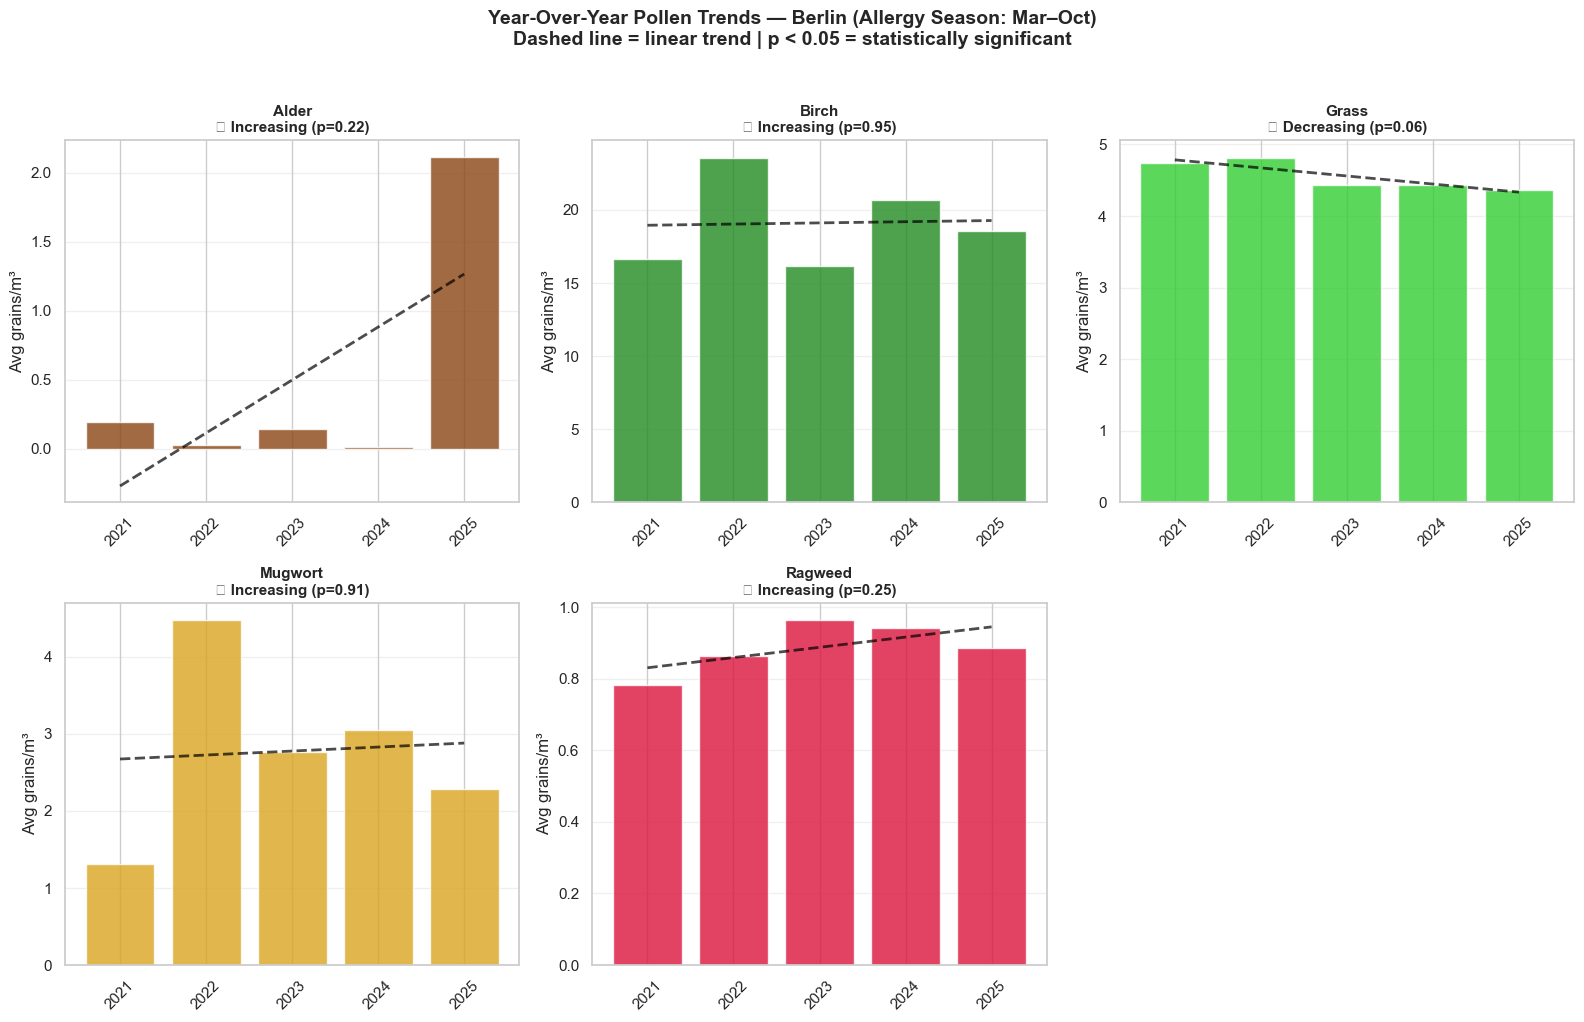

In [9]:
# ── Year-over-year: total pollen load per year (sum of daily means) ──
# Focus on allergy season (March–October) to avoid winter noise
season_df = df[df["month"].between(3, 10)]
yearly = season_df.groupby("year")[POLLEN_TYPES].mean()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, species in enumerate(POLLEN_TYPES):
    ax = axes[i]
    years = yearly.index
    values = yearly[species]

    ax.bar(years, values, color=pollen_colors[species], alpha=0.8)

    # Add trend line
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, values)
    trend_line = slope * years + intercept
    ax.plot(years, trend_line, color="black", linestyle="--", linewidth=2, alpha=0.7)

    direction = "📈 Increasing" if slope > 0 else "📉 Decreasing"
    significance = "✓" if p_value < 0.05 else "✗"
    ax.set_title(f"{species}\n{direction} (p={'<0.05' if p_value < 0.05 else f'{p_value:.2f}'})",
                 fontsize=11, fontweight="bold")
    ax.set_ylabel("Avg grains/m³")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", alpha=0.3)

# Remove unused subplot
axes[5].set_visible(False)

fig.suptitle(f"Year-Over-Year Pollen Trends — {CITY} (Allergy Season: Mar–Oct)\n"
             f"Dashed line = linear trend | p < 0.05 = statistically significant",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("data/yearly_trends.png", dpi=150, bbox_inches="tight")
plt.show()

**Takeaway:** No statistically significant year-over-year trend was detected for any species (all p-values > 0.05). With only 5 years of data, this is expected — pollen production varies considerably year to year due to weather conditions. A longer observation window (10–20+ years) would be needed to detect a meaningful climate-driven trend.

## 5. Weather ↔ Pollen Correlation

One of the most interesting questions: **does weather drive pollen levels?** We'll look at how temperature, humidity, wind speed, and rainfall relate to total pollen counts using a correlation heatmap

In [10]:
# ── Total pollen column for correlation analysis ──
df["Total Pollen"] = df[POLLEN_TYPES].sum(axis=1)

# Use daily averages for cleaner correlation 
daily = df.groupby("date").agg({
    "Total Pollen": "mean",
    "Alder": "mean",
    "Birch": "mean",
    "Grass": "mean",
    "Mugwort": "mean",
    "Ragweed": "mean",
    "Temperature (°C)": "mean",
    "Humidity (%)": "mean",
    "Wind Speed (km/h)": "mean",
    "Precipitation (mm)": "sum",  # daily total precip
    "month": "first",
    "year": "first",
    "season": "first",
    "day_of_year": "first",
    "hour": "first"
}).reset_index()

# Filter to allergy season only (no point correlating winter zeros)
daily_season = daily[daily["month"].between(3, 10)].copy()

weather_vars = ["Temperature (°C)", "Humidity (%)", "Wind Speed (km/h)", "Precipitation (mm)"]


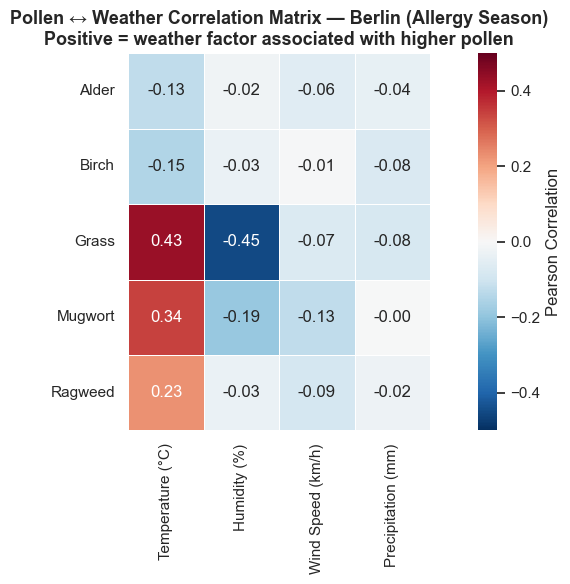


📌 Interpretation guide:
   • Positive correlation → higher values of that weather factor = more pollen
   • Negative correlation → higher values = less pollen
   • |r| > 0.3 is a moderate correlation, |r| > 0.5 is strong


In [11]:
# ── Correlation heatmap: all pollen types vs all weather factors ──
corr_cols = POLLEN_TYPES + weather_vars
corr_matrix = daily_season[corr_cols].corr()

# Extract just the pollen-weather cross section
pollen_weather_corr = corr_matrix.loc[POLLEN_TYPES, weather_vars]

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pollen_weather_corr, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-0.5, vmax=0.5, linewidths=0.5,
            square=True, ax=ax,
            cbar_kws={"label": "Pearson Correlation"})

ax.set_title(f"Pollen ↔ Weather Correlation Matrix — {CITY} (Allergy Season)\n"
             f"Positive = weather factor associated with higher pollen",
             fontsize=13, fontweight="bold")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig("data/correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n📌 Interpretation guide:")
print("   • Positive correlation → higher values of that weather factor = more pollen")
print("   • Negative correlation → higher values = less pollen")
print("   • |r| > 0.3 is a moderate correlation, |r| > 0.5 is strong")

## 6. Allergy Calendar — Daily Pollen Severity by Day of Year

A bar chart showing average total pollen by day-of-year across all 5 years, color-coded by severity. This reveals the "danger zones" for allergy sufferers at a glance.

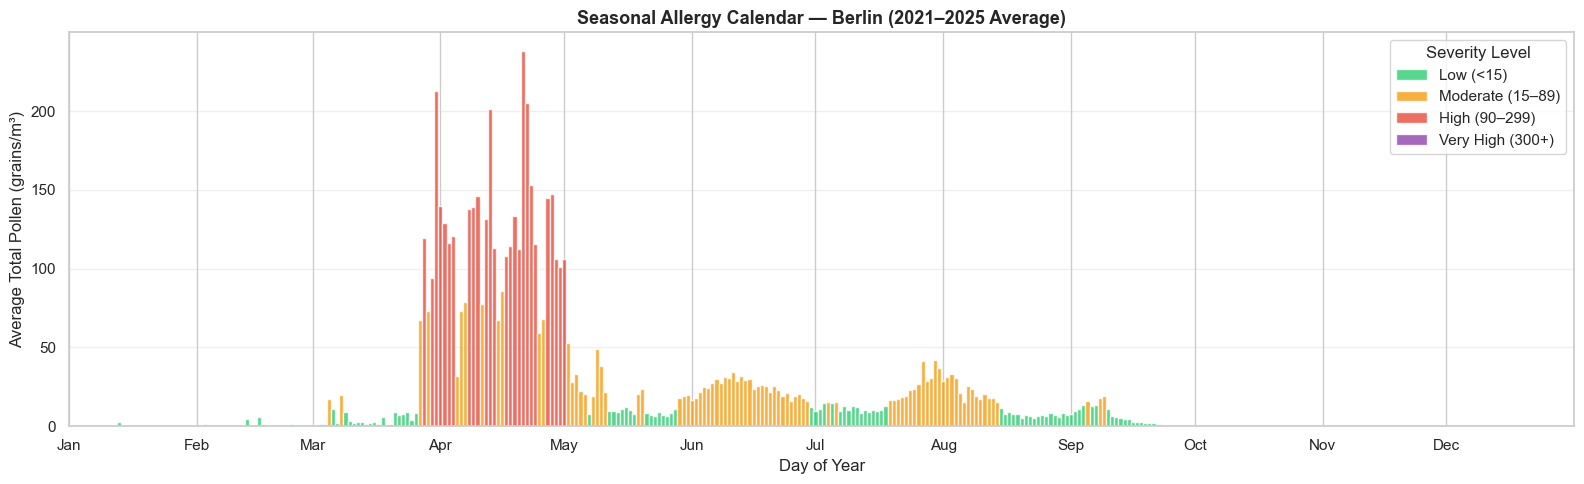

In [12]:
# ── Allergy calendar: average total pollen by day-of-year ──
daily_avg_by_doy = df.groupby("day_of_year")["Total Pollen"].mean().reset_index()

# Create a nicer x-axis with month markers
month_starts_doy = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

fig, ax = plt.subplots(figsize=(16, 5))

# Color-code by severity: green → yellow → orange → red
colors = daily_avg_by_doy["Total Pollen"].apply(
    lambda v: "#2ecc71" if v < 15 else "#f39c12" if v < 90 else "#e74c3c" if v < 300 else "#8e44ad"
)

ax.bar(daily_avg_by_doy["day_of_year"], daily_avg_by_doy["Total Pollen"],
       color=colors, width=1.0, alpha=0.8)

ax.set_xticks(month_starts_doy)
ax.set_xticklabels(month_labels)
ax.set_xlabel("Day of Year", fontsize=12)
ax.set_ylabel("Average Total Pollen (grains/m³)", fontsize=12)
ax.set_title(f"Seasonal Allergy Calendar — {CITY} ({START_YEAR}–{END_YEAR} Average)",
             fontsize=13, fontweight="bold")
ax.set_xlim(1, 366)
ax.grid(axis="y", alpha=0.3)

# Create custom legend for severity levels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.8, label='Low (<15)'),
    Patch(facecolor='#f39c12', alpha=0.8, label='Moderate (15–89)'),
    Patch(facecolor='#e74c3c', alpha=0.8, label='High (90–299)'),
    Patch(facecolor='#8e44ad', alpha=0.8, label='Very High (300+)')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, title='Severity Level')

plt.tight_layout()
plt.savefig("data/allergy_calendar.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Top Allergens by Season

Breaking down which specific pollen types dominate each season — useful for knowing *what* to blame for your symptoms at different times of year.

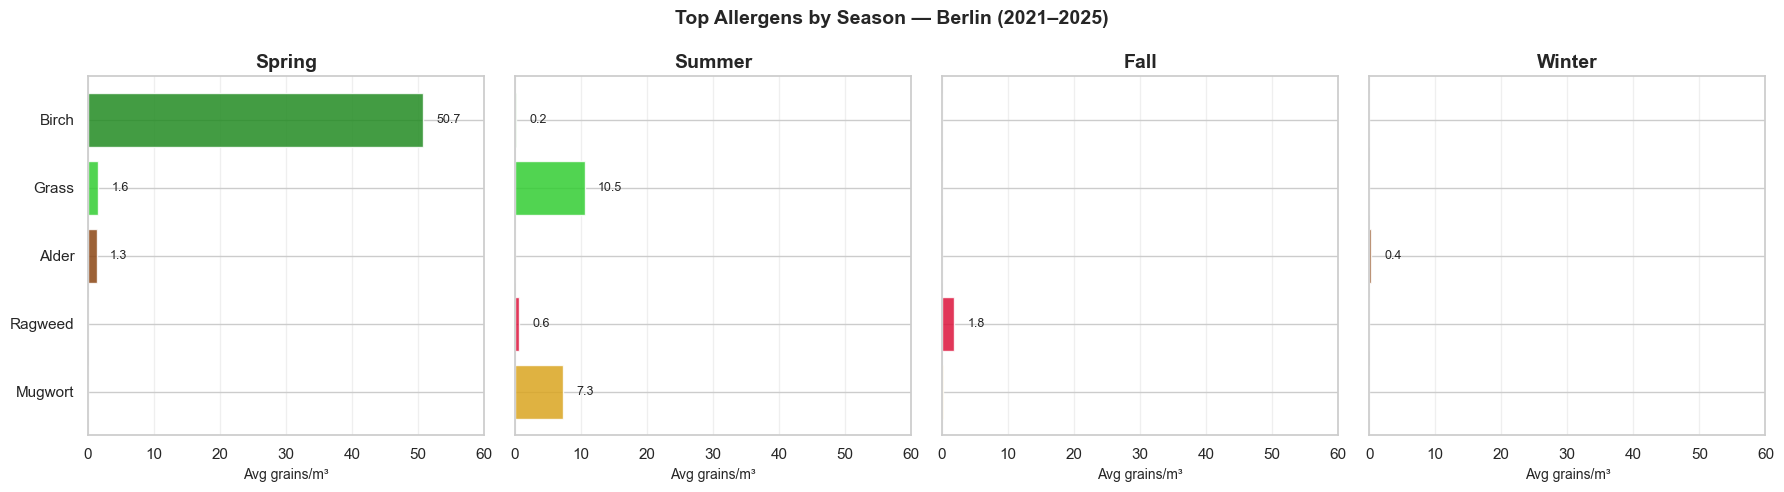

📌 Spring is dominated by tree pollens (Birch, Alder)
   Summer is grass season
   Fall brings Ragweed
   Winter provides relief — near-zero across the board


In [13]:
# ── Top allergens by season ──
season_order = ["Spring", "Summer", "Fall", "Winter"]
seasonal_avg = df.groupby("season")[POLLEN_TYPES].mean().reindex(season_order)

# Global max across all seasons — so bars are comparable at a glance
global_max = seasonal_avg.values.max()
label_offset = global_max * 0.04

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True, sharex=True)

for i, season in enumerate(season_order):
    ax = axes[i]
    values = seasonal_avg.loc[season].sort_values(ascending=True)
    colors = [pollen_colors[name] for name in values.index]

    bars = ax.barh(values.index, values.values, color=colors, alpha=0.85)
    ax.set_title(season, fontsize=14, fontweight="bold")
    ax.set_xlabel("Avg grains/m³", fontsize=10)

    # Add value labels — read actual bar positions from bar geometry
    for bar in bars:    
        val = bar.get_width()
        if val > 0.1:
            y_pos = bar.get_y() + bar.get_height() / 2
            ax.text(val + label_offset, y_pos, f"{val:.1f}", va="center", fontsize=9)

    ax.grid(axis="x", alpha=0.3)

# Set x-axis limit to 60
axes[0].set_xlim(right=60)

fig.suptitle(f"Top Allergens by Season — {CITY} ({START_YEAR}–{END_YEAR})",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("data/top_allergens_by_season.png", dpi=150, bbox_inches="tight")
plt.show()

print("📌 Spring is dominated by tree pollens (Birch, Alder)")
print("   Summer is grass season")
print("   Fall brings Ragweed")
print("   Winter provides relief — near-zero across the board")

## 8. Pollen Severity Distribution Over Time (Interactive)

An interactive Plotly chart showing the proportion of days at each severity level per year. This tells the full story — not just averages, but how often people face *bad* days.

In [14]:
# ── Severity distribution by year (stacked bar — interactive) ──
# Reuse the per-species AAAAI severity classifications from Section 2.
# For each day, take the worst severity observed across any species at any hour.
severity_rank = {"Absent": 0, "Low": 1, "Moderate": 2, "High": 3, "Very High": 4}
rank_to_severity = {v: k for k, v in severity_rank.items()}
severity_cols = [f"{s}_severity" for s in POLLEN_TYPES]

# Worst severity per day: max rank across all species and all hours
daily_worst = (
    df[severity_cols]
    .replace(severity_rank)
    .max(axis=1)
    .groupby(df["date"])
    .max()
)
daily["severity"] = daily["date"].map(daily_worst).map(rank_to_severity)

# Focus on allergy season
daily_szn = daily[daily["month"].between(3, 10)]

severity_by_year = daily_szn.groupby(["year", "severity"]).size().unstack(fill_value=0)
severity_order = ["Absent", "Low", "Moderate", "High", "Very High"]
severity_by_year = severity_by_year.reindex(columns=severity_order, fill_value=0)

# Convert to percentages
severity_pct = severity_by_year.div(severity_by_year.sum(axis=1), axis=0) * 100

severity_colors = {
    "Absent": "#bdc3c7",
    "Low": "#2ecc71",
    "Moderate": "#f39c12",
    "High": "#e74c3c",
    "Very High": "#8e44ad"
}

fig = go.Figure()
for level in severity_order:
    fig.add_trace(go.Bar(
        name=level,
        x=severity_pct.index,
        y=severity_pct[level],
        marker_color=severity_colors[level]
    ))

fig.update_layout(
    barmode="stack",
    title=f"Allergy Severity Distribution by Year — {CITY} (Mar–Oct)<br>"
          f"<sub>Worst AAAAI severity across any species on each day</sub>",
    xaxis_title="Year",
    yaxis_title="% of Days",
    yaxis=dict(range=[0, 100]),
    legend_title="Severity",
    template="plotly_white",
    height=500
)

fig.show()

## 9. Hourly Patterns — When Is Pollen Worst During the Day?

Research suggests pollen counts tend to peak in the morning. Let's see if the hourly data confirms that — useful for planning outdoor activities.

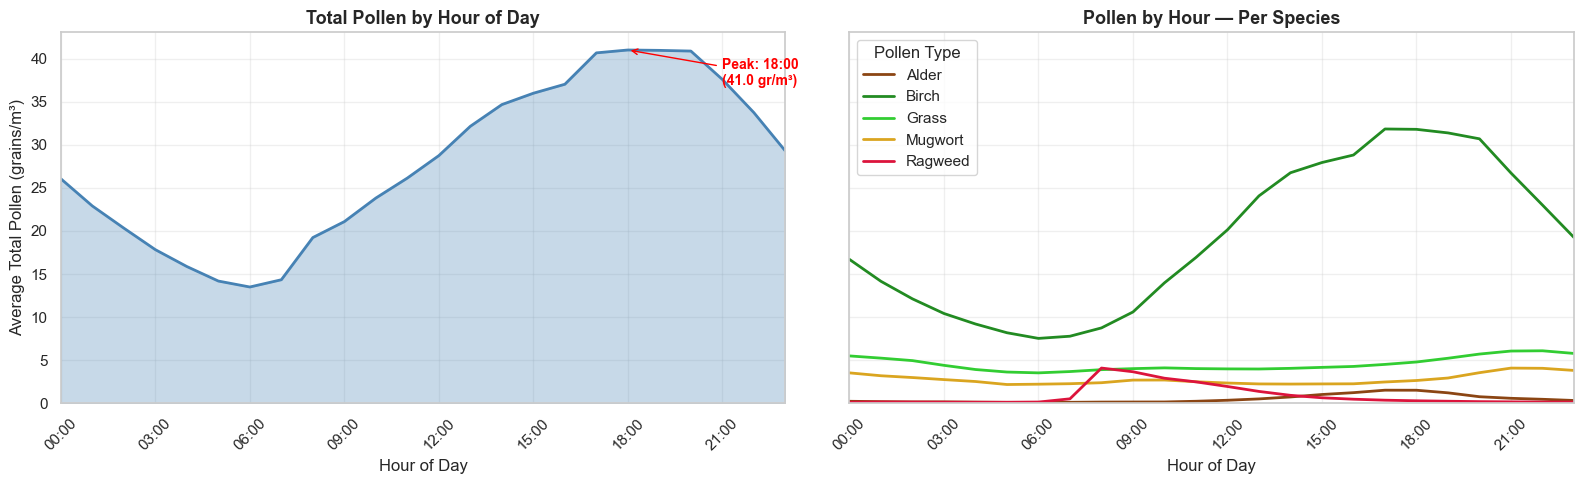

In [15]:

# ── Hourly pollen patterns (allergy season only) ──
hourly_season = df[df["month"].between(3, 10)]
hourly_avg = hourly_season.groupby("hour")[POLLEN_TYPES + ["Total Pollen"]].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Left: Total pollen by hour
ax1.fill_between(hourly_avg.index, hourly_avg["Total Pollen"],
                 alpha=0.3, color="steelblue")
ax1.plot(hourly_avg.index, hourly_avg["Total Pollen"],
         color="steelblue", linewidth=2)
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Average Total Pollen (grains/m³)", fontsize=12)
ax1.set_title("Total Pollen by Hour of Day", fontsize=13, fontweight="bold")
ax1.set_xticks(range(0, 24, 3))
ax1.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 3)], rotation=45)
ax1.set_xlim(0, 23)
ax1.set_ylim(bottom=0)
ax1.grid(alpha=0.3)

# Highlight peak hour
peak_hour = hourly_avg["Total Pollen"].idxmax()
peak_val = hourly_avg["Total Pollen"].max()
ax1.annotate(f"Peak: {peak_hour:02d}:00\n({peak_val:.1f} gr/m³)",
             xy=(peak_hour, peak_val), xytext=(peak_hour + 3, peak_val * 0.9),
             arrowprops=dict(arrowstyle="->", color="red"),
             fontsize=10, color="red", fontweight="bold")

# Right: Each species by hour
for species in POLLEN_TYPES:
    ax2.plot(hourly_avg.index, hourly_avg[species],
             label=species, color=pollen_colors[species], linewidth=2)

ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_title("Pollen by Hour — Per Species", fontsize=13, fontweight="bold")
ax2.set_xticks(range(0, 24, 3))
ax2.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 3)], rotation=45)
ax2.set_xlim(0, 23)
ax2.legend(title="Pollen Type", frameon=True)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("data/hourly_patterns.png", dpi=150, bbox_inches="tight")
plt.show()


## 10. Rainfall & Pollen — The Day-After Effect

A well-known phenomenon: rain washes pollen out of the air temporarily, but pollen counts often *surge* the day after rain. Let's test this with the data.

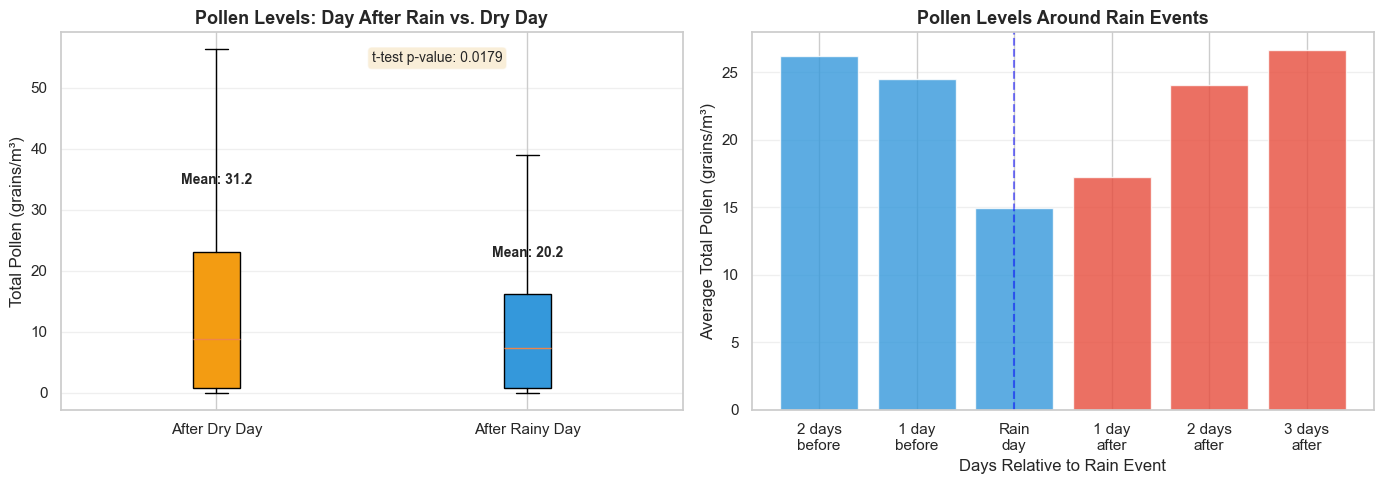

In [16]:
# ── Day-after-rain effect ──
daily_sorted = daily_szn.sort_values("date").copy()
daily_sorted["prev_day_rain"] = daily_sorted["Precipitation (mm)"].shift(1)
daily_sorted["rained_yesterday"] = daily_sorted["prev_day_rain"] > 1.0  # >1mm = meaningful rain

# Compare pollen on days after rain vs. days after no rain
after_rain = daily_sorted[daily_sorted["rained_yesterday"] == True]["Total Pollen"]
after_dry = daily_sorted[daily_sorted["rained_yesterday"] == False]["Total Pollen"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Box plot comparison
data_to_plot = [after_dry.dropna(), after_rain.dropna()]
bp = ax1.boxplot(data_to_plot, labels=["After Dry Day", "After Rainy Day"],
                  patch_artist=True, showfliers=False)
bp["boxes"][0].set_facecolor("#f39c12")
bp["boxes"][1].set_facecolor("#3498db")

ax1.set_ylabel("Total Pollen (grains/m³)", fontsize=12)
ax1.set_title("Pollen Levels: Day After Rain vs. Dry Day", fontsize=13, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

# Add means as text
mean_dry = after_dry.mean()
mean_rain = after_rain.mean()
ax1.text(1, mean_dry * 1.1, f"Mean: {mean_dry:.1f}", ha="center", fontsize=10, fontweight="bold")
ax1.text(2, mean_rain * 1.1, f"Mean: {mean_rain:.1f}", ha="center", fontsize=10, fontweight="bold")

# Statistical test
t_stat, p_val = stats.ttest_ind(after_dry.dropna(), after_rain.dropna())
ax1.text(0.5, 0.95, f"t-test p-value: {p_val:.4f}",
         transform=ax1.transAxes, fontsize=10, verticalalignment="top",
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

# Right: rolling pollen around rain events
# Show average pollen from 2 days before to 2 days after rain
daily_sorted["rain_event"] = daily_sorted["Precipitation (mm)"] > 2.0
rain_dates = daily_sorted[daily_sorted["rain_event"]].index


offsets = range(-2, 4)
avg_pollen_around_rain = []
for offset in offsets:
    shifted = daily_sorted["Total Pollen"].shift(-offset)
    avg_val = shifted[rain_dates].mean()
    avg_pollen_around_rain.append(avg_val)

ax2.bar(offsets, avg_pollen_around_rain,
        color=["#3498db" if o <= 0 else "#e74c3c" for o in offsets], alpha=0.8)
ax2.axvline(x=0, color="blue", linestyle="--", alpha=0.5, label="Rain day")
ax2.set_xlabel("Days Relative to Rain Event", fontsize=12)
ax2.set_ylabel("Average Total Pollen (grains/m³)", fontsize=12)
ax2.set_title("Pollen Levels Around Rain Events", fontsize=13, fontweight="bold")
ax2.set_xticks(list(offsets))
ax2.set_xticklabels(["2 days\nbefore", "1 day\nbefore", "Rain\nday",
                      "1 day\nafter", "2 days\nafter", "3 days\nafter"])
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("data/rain_effect.png", dpi=150, bbox_inches="tight")
plt.show()

## Key Findings

### Seasonal Patterns
- **Spring (Mar–May)**: Tree pollen season — Birch and Alder dominate, with Birch producing the highest single-species counts in the dataset
- **Summer (Jun–Aug)**: Grass pollen peaks — the most common outdoor allergen
- **Fall (Sep–Nov)**: Weed pollen — Ragweed and Mugwort take over
- **Winter (Dec–Feb)**: Near-zero pollen — relief for allergy sufferers

### Weather Correlations
- **Temperature** is the only weather factor with a meaningful correlation to pollen — but only for summer/fall species: Grass (r=0.43), Mugwort (r=0.34), and Ragweed (r=0.23). Tree pollens (Birch, Alder) showed no meaningful temperature correlation
- **Humidity** has a moderate negative correlation with Grass pollen (r=−0.45), but negligible relationships with all other species
- **Wind speed and precipitation** showed no meaningful correlation with any pollen type (all |r| < 0.15)
- Overall, weather alone is a weak predictor of daily pollen levels — seasonal timing matters far more than day-to-day weather conditions

### Year-Over-Year Trends
- No statistically significant trends were detected over the 2021–2025 window (p > 0.05 for all species)
- Year-to-year variability is high, driven largely by seasonal weather differences
- A longer observation period (10–20+ years) would be needed to detect climate-driven shifts in pollen production or season length

### Hourly Patterns
- Species behave very differently throughout the day — there is no single "peak pollen hour"
- **Birch & Alder** (tree pollens): build through the day, peaking in the late afternoon (~17:00–18:00)
- **Grass & Mugwort**: relatively steady throughout the day, with a slight rise in the evening (~21:00–22:00)
- **Ragweed**: the outlier — spikes sharply in the early morning (~08:00), then tapers off for the rest of the day
- All species are lowest in the early morning hours (05:00–06:00)

---

*Data: 5 years of hourly observations from [Open-Meteo](https://open-meteo.com/en/docs/air-quality-api) / CAMS European Air Quality Forecast*
*Severity classification: [AAAAI](https://www.aaaai.org/) (American Academy of Allergy, Asthma & Immunology)*